* 下文涉及对角度的描述中，1°、1′、1″分别表示角度1度、1分、1秒，1°= 60′= 3600″。
* 数据集涉及GeoTIFF和NetCDF两种格式的文件。这两种文件都可以采用Python和R等开源编程软件处理，也可以采用地理数据处理软件如ArcGIS、GeoScene、SuperMap、QGIS等进行处理。其中QGIS是免费开源的地理信息处理软件，任何人都可下载使用。
* QGIS官方网站：https://qgis.org/
* QGIS教程：https://docs.qgis.org/3.34/en/docs/training_manual/index.html
				https://www.osgeo.cn/qgis-tutorial/index.html（中文教程）

* 1.中国数字高程图（1km）

* 2.中国0.1°近地表气温数据集（1979-2018年）

* 3.中国大陆0.25°逐日降水数据集（1961-2022年）

* 4.中国0.5°土地利用和覆盖变化数据集（1900-2019年）

* 5.中国大陆1km逐年历史人口空间分布公里网格数据集（1990-2015年）

* 6.中国大陆1km逐年历史GDP空间分布公里网格数据集（1990-2015年）

2.近年来，以暴雨为代表的极端天气事件对人类的生产生活造成了越来越难以忽视的影响。请结合附件中所给的数据，建立数学模型，说明地形-气候相互作用在极端天气形成过程中的作用。

#### 用高程和温度数据来解释降水，用高程和降水来解释温度，即可说明三者之间的相互作用

In [1]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import rasterio
import netCDF4 as nc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号


In [2]:
def img_show(name,image_data,bounds,width,height,style,cmap_wid):
    left, bottom, right, top = bounds
    # 计算图像的网格经纬度
    xs = np.linspace(left, right, width)
    ys = np.linspace(bottom, top, height)
    X, Y = np.meshgrid(xs, ys)

    # 显示 GeoTIFF 图像
    plt.figure(figsize=(10, 6))
    plt.imshow(image_data, cmap=style, extent=[left, right, bottom, top])
    plt.title(name,fontsize = 14)
    plt.xlabel('经度',fontsize = 14)
    plt.ylabel('纬度',fontsize = 14)
    #plt.colorbar(label='降水量')  # 添加标签

    # 获取当前轴
    ax = plt.gca()

    # 使用 make_axes_locatable 创建一个分隔器，控制 colorbar 的位置和大小
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # 调整 colorbar 宽度和与图像的间距
    # 添加颜色条
    cbar = plt.colorbar(cax=cax)

    # 设置颜色条的宽高比，使其更短或更长
    cax.set_aspect(cmap_wid)  # 值越大，颜色条越短
    plt.savefig(f'F:\研究生学习\华为杯\第二问图片\\{name}.png', bbox_inches='tight')

#### 高程数据提取

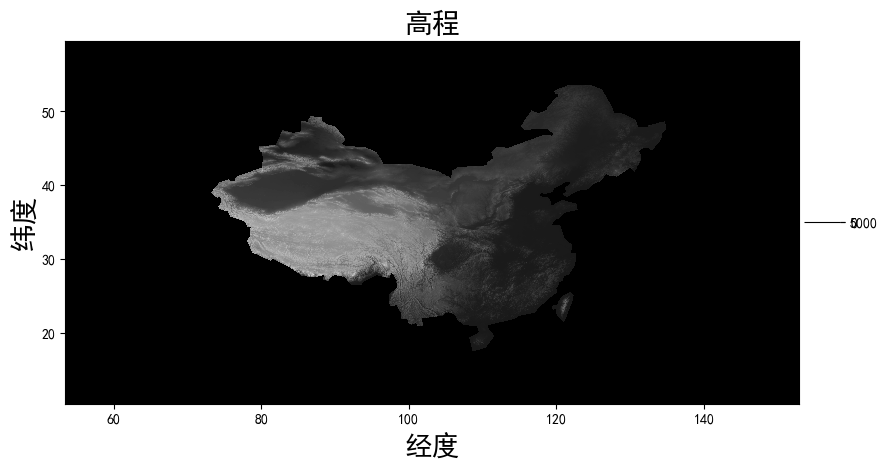

In [23]:
# 读取 GeoTIFF 文件
file_path = r'F:\研究生学习\华为杯\数据集1\中国数字高程图(1km)\Geo\TIFF\chinadem_geo.tif'

with rasterio.open(file_path) as dataset:
    # 读取像素值
    image_altitude = dataset.read(1)  # 读取第一个波段的数据
    image_altitude[image_altitude<-1000] = -1000
    # 获取经纬度信息
    bounds = dataset.bounds
    left, bottom, right, top = bounds
    transform = dataset.transform

    # 获取图像尺寸
    longitude = dataset.width
    latitude = dataset.height
    
    xs_altitude = np.linspace(left, right, dataset.width)
    ys_altitude = np.linspace(bottom, top, dataset.height)
    X_altitude, Y_altitude = np.meshgrid(xs_altitude, ys_altitude)
    
img_show('高程',image_altitude,bounds,longitude,latitude,'gray',0.003)


#### 选取1990年到2018年的降水数据（因为温度数据只有截止到2018年）

In [4]:
file_path = r'F:\CHM_PRE_0.25dg_19612022.nc'
dataset = nc.Dataset(file_path,encoding='gbk')


# 读取变量，例如时间、纬度、经度和数据变量
time = dataset.variables['time'][:].data

latitude = dataset.variables['latitude'][:].data
longitude = dataset.variables['longitude'][:].data
years = dataset.variables['years'][:].data.tolist()
pre = dataset.variables['pre'][:].data
pre[pre==-9.99e+01] = 0
station_number = dataset.variables['station_number'][:].data
bounds = [longitude.min(),latitude.min(),longitude.max(),latitude.max()]

base_time = datetime(1961, 1, 1, 0, 0, 0)
actual_dates = np.array([(base_time + timedelta(hours=hours)).year for hours in time])
pre = pre[(actual_dates>=2018)&(actual_dates<=2018)] #筛选后降水量
time = time[(actual_dates>=2018)&(actual_dates<=2018)] #筛选后时间
width = len(longitude)
height = len(latitude)

xs_pre = np.linspace(left, right, width)
ys_pre = np.linspace(bottom, top, height)
X_pre, Y_pre = np.meshgrid(xs_pre, ys_pre) #降水数据的网格数据

C:\Users\Administrator\AppData\Local\Temp\ipykernel_44540\3713700876.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  pre = dataset.variables['pre'][:].data


#### 选择2018年的温度数据

In [5]:
import os
abs_path = r'F:\研究生学习\华为杯\数据集2\日平均数据'
dirs = os.listdir(abs_path)
temp = []
for filename in dirs:
    print(filename)
    sub_dirs = os.listdir(f'{abs_path}\\{filename}')
    for sub_file in sub_dirs:
        if '.tif' in sub_file and int(sub_file[:4])>=2018 and int(sub_file[:4])<= 2018:
            with rasterio.open(f'{abs_path}\\{filename}\\{sub_file}') as dataset:
                # 读取像素值
                image_data = dataset.read(1)  # 读取第一个波段的数据
                # 获取经纬度信息
                bounds = dataset.bounds
                left, bottom, right, top = bounds
                transform = dataset.transform

                # 获取图像尺寸
                width = dataset.width
                height = dataset.height
                
                xs_temp = np.linspace(left, right, width) #温度图的网格数据
                ys_temp = np.linspace(bottom, top, height) #温度图的网格数据
                X_temp, Y_temp = np.meshgrid(xs_temp, ys_temp)

                temp.append(image_data)
temp = np.array(temp)
temp.shape

1979_avg
1980_avg
1981_avg
1982_avg
1983_avg
1984_avg
1985_avg
1986_avg
1987_avg
1988_avg
1989_avg
1990_avg
1991_avg
1992_avg
1993_avg
1994_avg
1995_avg
1996_avg
1997_avg
1998_avg
1999_avg
2000_avg
2001_avg
2002_avg
2003_avg
2004_avg
2005_avg
2006_avg
2007_avg
2008_avg
2009_avg
2010_avg
2011_avg
2012_avg
2013_avg
2014_avg
2015_avg
2016_avg
2017_avg
2018_avg


(365, 400, 700)

#### 植被数据

In [6]:
def function(veg):
    ls = []
    for year in years:
        with rasterio.open(f'{file_path}\\{veg}-{year}.tif') as dataset:
            # 读取像素值
            image_data = dataset.read(1)  # 读取第一个波段的数据
            # 获取经纬度信息
            bounds = dataset.bounds
            left, bottom, right, top = bounds
            transform = dataset.transform

            # 获取图像尺寸
            width = dataset.width
            height = dataset.height

            # 计算图像的网格经纬度
            longitude = np.linspace(left, right, width)
            latitude = np.linspace(bottom, top, height)
            ls.append(image_data)
    return np.array(ls),longitude,latitude,bounds,width,height

veges = ['cropland','forest','grass','shrub','wetland']
years = list(range(2018,2019))

file_path = r'F:\研究生学习\华为杯\数据集4\中国大陆0.5°土地利用和覆盖变化数据集(1900-2019年)\数据实体'

cropland,longitude,latitude,bounds,width,height = function('cropland')
cropland = cropland[0]
forest = function('forest')[0][0]
grass = function('grass')[0][0]
shrub = function('shrub')[0][0]
wetland = function('wetland')[0][0]

left, bottom, right, top = bounds
xs_veg = np.linspace(left, right, width) #温度图的网格数据
ys_veg = np.linspace(bottom, top, height) #温度图的网格数据
X_veg, Y_veg = np.meshgrid(xs_veg, ys_veg)

#### 现在，我们有了地形数据、温度数据、降水数据和植被数据，但它们的分辨率不同，地形数据有接近50W个像素点，而植被数据只有10000个像素点。考虑到我们需要基于每一天的温度、植被、降水以及地形情况，来刻画不同内容对极端天气的影响，所以数据量太过于庞大，所以我们对数据进行降维处理

#### 因此，我们需要将粒度更细的矩阵进行降维，按照近邻相似的匹配方法，我们将大矩阵中的所有经纬度匹配到植被矩阵所在的经纬度，并且按照每个小矩阵经纬度匹配到的个数对数据进行平均处理

In [7]:
import numpy as np
from scipy.spatial import cKDTree
def matrix_concat(xs,ys):
    matrix = []
    for i in range(xs.shape[0]):
        tem = []
        for o in range(xs.shape[1]):
            tem.append([xs[i][o],ys[i][o]])
        matrix.append(tem)
    return np.array(matrix)

def reduction(X_big,Y_big,X_small,Y_small,values):
    # 示例大矩阵 (例如包含大范围的经纬度点)
    large_lat_lon = matrix_concat(X_big,Y_big).reshape(-1,2)  # 大矩阵经纬度
    large_matrix_values = values.reshape(1,-1)[0]  # 大矩阵对应值

    # 示例小矩阵 (包含小范围的经纬度点)
    small_lat_lon = matrix_concat(X_small,Y_small).reshape(-1,2)  # 小矩阵经纬度

    # 创建KD-Tree来寻找最近邻点
    tree = cKDTree(small_lat_lon)

    # 为大矩阵中的每个经纬度点找到小矩阵中最近的点
    distances, indices = tree.query(large_lat_lon)

    # 初始化小矩阵的值为零
    small_matrix_values = np.zeros(len(small_lat_lon))

    # 初始化一个计数器，用于计算每个小矩阵点被匹配到多少次
    count = np.zeros(len(small_lat_lon))

    # 遍历大矩阵，将大矩阵的值加到相应的最近邻小矩阵点上
    for i, idx in enumerate(indices):
        small_matrix_values[idx] += large_matrix_values[i]
        count[idx] += 1

    # 对每个小矩阵点求平均值，避免被零除
    small_matrix_values = np.divide(small_matrix_values, count, out=np.zeros_like(small_matrix_values), where=count!=0)
    return small_matrix_values

In [8]:
altitude_values = reduction(X_altitude,Y_altitude,X_veg,Y_veg,image_altitude) #高程

altitude_values = np.array([altitude_values for i in pre])

pre_values = np.array([reduction(X_pre,Y_pre,X_veg,Y_veg,i) for i in pre]) #降水

temp_values = np.array([reduction(X_temp,Y_temp,X_veg,Y_veg,i) for i in temp]) #温度

ll = matrix_concat(X_veg,Y_veg).reshape(-1,2) #经纬度
lonlatitude = np.array([ll for i in pre])

cropland_values = np.array([cropland for i in pre])
forest_values = np.array([forest for i in pre])
grass_values = np.array([grass for i in pre])
shrub_values = np.array([shrub for i in pre])
wetland_values = np.array([wetland for i in pre])

#### 初始中国境内数据

In [ ]:
dataset = pd.DataFrame()
dataset['高程'] = altitude_values.reshape(1,-1)[0]
dataset['降水'] = pre_values.reshape(1,-1)[0]
dataset['气温'] = temp_values.reshape(1,-1)[0]
dataset['耕地'] = cropland_values.reshape(1,-1)[0]
dataset['森林'] = forest_values.reshape(1,-1)[0]
dataset['草地'] = grass_values.reshape(1,-1)[0]
dataset['灌木'] = shrub_values.reshape(1,-1)[0]
dataset['湿地'] = wetland_values.reshape(1,-1)[0]
dataset['经度'] = lonlatitude.reshape(-1,2)[:,0]
dataset['纬度'] = lonlatitude.reshape(-1,2)[:,1]

dataset['是否中国'] = 1
dataset.loc[(dataset.气温<=-50)|(dataset.高程<=-100)|((dataset.耕地==0)&(dataset.森林==0)&(dataset.草地==0)&(dataset.灌木==0)&(dataset.湿地==0)),'是否中国'] = 0

result = dataset[dataset.是否中国==1].sort_values(by=['经度','纬度'])
result

#### 在分析极端天气时，定义合适的标准是至关重要的。基于你的数据（地形高程、温度、植被覆盖率、经纬度、降水），可以根据以下标准定义暴雨、热浪、寒潮和干旱的阈值。每个定义都可以根据特定地区的气候条件和历史事件进行调整。

### 1. **暴雨 (Heavy Rainfall)**

暴雨通常是指在短时间内降水量显著超过常规水平。暴雨的定义可以根据日降水量来设置，具体标准如下：

- **定义**：24小时内的累计降水量超过某个阈值，通常这个阈值根据地区平均降水量来设定。
- **参考标准**：
  - 中等暴雨：24小时降水量 > 50毫米。
  - 强暴雨：24小时降水量 > 100毫米。
  - 特大暴雨：24小时降水量 > 200毫米。
- **数据来源**：利用你所收集的降水数据按时间维度计算累计降水量，提取暴雨发生频率。

### 2. **热浪 (Heatwave)**

热浪定义为连续多天的高温天气。具体标准可以根据气温的历史百分位数和日最高温度来确定。

- **定义**：日最高温度连续数天超过某个高温阈值。
- **参考标准**：
  - **日最高温度**：连续3天以上的日最高温度超过当地历史日最高温度90或95百分位。
  - **绝对高温**：日最高温度连续超过35°C，视为较强的热浪。
- **数据来源**：使用温度数据，计算每一天的最高温度，识别连续高温事件并设定持续天数的条件。

### 3. **寒潮 (Cold Wave)**

寒潮通常指气温在短时间内急剧下降并维持较低温度的现象。定义寒潮时可以参考温度的急剧下降和低温持续时间。

- **定义**：短期内气温急剧下降，且最低气温持续低于某个阈值。
- **参考标准**：
  - **急剧降温**：24小时内气温骤降超过8°C，或48小时内气温下降超过10°C。
  - **低温**：最低温度连续2-3天低于某个极端低温值。例如，最低温度连续3天低于0°C，或当地历史最低气温10%以下。
- **数据来源**：从温度数据中提取最低温度变化，并识别温度骤降的时间段。


### 因变量（Y):存在极端天气记为1，否则为0

#### 构建极端天气

In [10]:
import pandas as pd
import numpy as np
# 初始化极端天气的列为0
result['heavy_rain'] = 0
result['heatwave'] = 0
result['cold_wave'] = 0

# 暴雨标准：24小时降水量 > 50mm为中等暴雨，>100mm为强暴雨
result.loc[result['降水'] > 50, 'heavy_rain'] = 1

# 热浪标准：连续3天日最高温度 > 35°C
result['heatwave'] = (
    (result['气温'].rolling(window=3).min() > 35).astype(int)
)

# 寒潮标准：24小时内降温 > 8°C 或48小时降温 > 10°C；最低温度 < 0°C 持续3天
result['temp_drop_24h'] = result['气温'].diff(periods=1).abs()  # 计算24小时内的温度变化
result['temp_drop_48h'] = result['气温'].diff(periods=2).abs()  # 计算48小时内的温度变化

result['cold_wave'] = np.where(
    (result['temp_drop_24h'] > 8) | (result['temp_drop_48h'] > 10) & (result['气温'].rolling(window=3).min() < 0),
    1, 0
)


# 删除临时列
result.drop(['temp_drop_24h', 'temp_drop_48h'], axis=1, inplace=True)

result['极端天气'] = [x|y|z for x,y,z in zip(result.heavy_rain,result.heatwave,result.cold_wave)]
result

高程    降水         气温        耕地        森林        草地   灌木  \
3689     4110.647003  0.00 -13.014723  0.000000  0.014729  0.985271  0.0   
13595    4110.647003  0.00 -16.472431  0.000000  0.014729  0.985271  0.0   
23501    4110.647003  0.02 -15.646087  0.000000  0.014729  0.985271  0.0   
33407    4110.647003  0.00 -15.552388  0.000000  0.014729  0.985271  0.0   
43313    4110.647003  0.00 -17.409271  0.000000  0.014729  0.985271  0.0   
...              ...   ...        ...       ...       ...       ...  ...   
3568060   101.131378  0.00 -18.306284  0.004478  0.001554  0.980469  0.0   
3577966   101.131378  0.00 -17.548406  0.004478  0.001554  0.980469  0.0   
3587872   101.131378  0.00 -16.521357  0.004478  0.001554  0.980469  0.0   
3597778   101.131378  0.00 -15.023550  0.004478  0.001554  0.980469  0.0   
3607684   101.131378  0.00 -14.928866  0.004478  0.001554  0.980469  0.0   

               湿地          经度         纬度  是否中国  heavy_rain  heatwave  \
3689     0.000000   75.248810  31.263312     1           0         0   
13595    0.000000   75.248810  31.263312     1           0         0   
23501    0.000000   75.248810  31.263312     1           0         0   
33407    0.000000   75.248810  31.263312     1           0         0   
43313    0.000000   75.248810  31.263312     1           0         0   
...           ...         ...        ...   ...         ...       ...   
3568060  0.013499  133.709127  23.665909     1           0         0   
3577966  0.013499  133.709127  23.665909     1           0         0   
3587872  0.013499  133.709127  23.665909     1           0         0   
3597778  0.013499  133.709127  23.665909     1           0         0   
3607684  0.013499  133.709127  23.665909     1           0         0   

         cold_wave  极端天气  
3689             0     0  
13595            0     0  
23501            0     0  
33407            0     0  
43313            0     0  
...            ...   ...  
3568060          0     0  
3577966          0     0  
3587872          0     0  
3597778          0     0  
3607684          0     0  

[1189535 rows x 15 columns]

#### 2018年总灾害情况

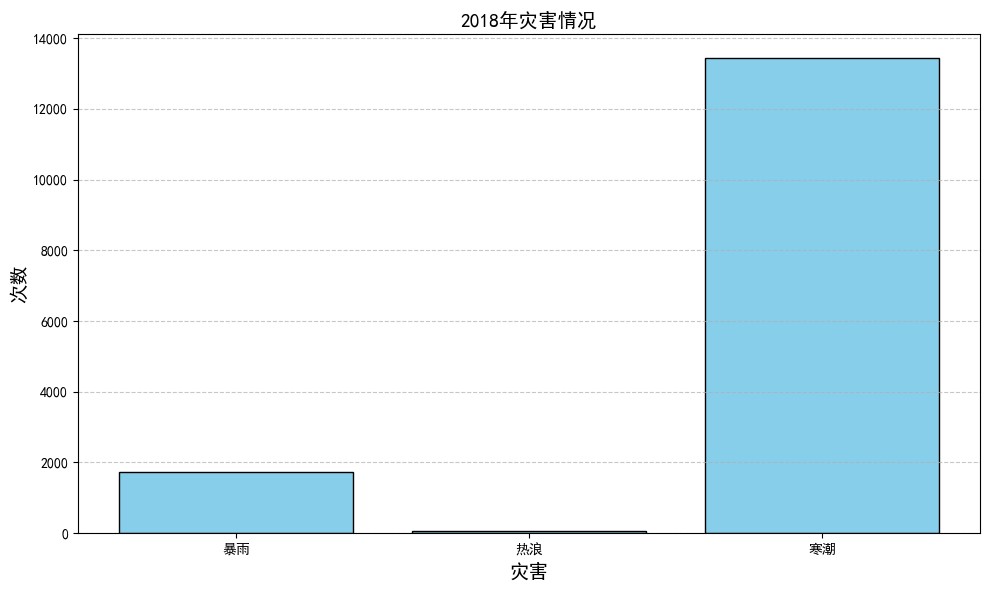

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = result[['heavy_rain','heatwave','cold_wave']].sum()
data.index = ['暴雨','热浪','寒潮']
# 创建条形图
plt.figure(figsize=(10, 6))
plt.bar(data.index, data.values, color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('2018年灾害情况', fontsize=14, fontweight='bold')
plt.xlabel('灾害', fontsize=14)
plt.ylabel('次数', fontsize=14)

# 美化图表
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f'F:\研究生学习\华为杯\第二问图片\\2018年灾害情况.png', bbox_inches='tight')
# 显示图表
plt.tight_layout()
plt.show()

#### 不同地理因素的分布情况

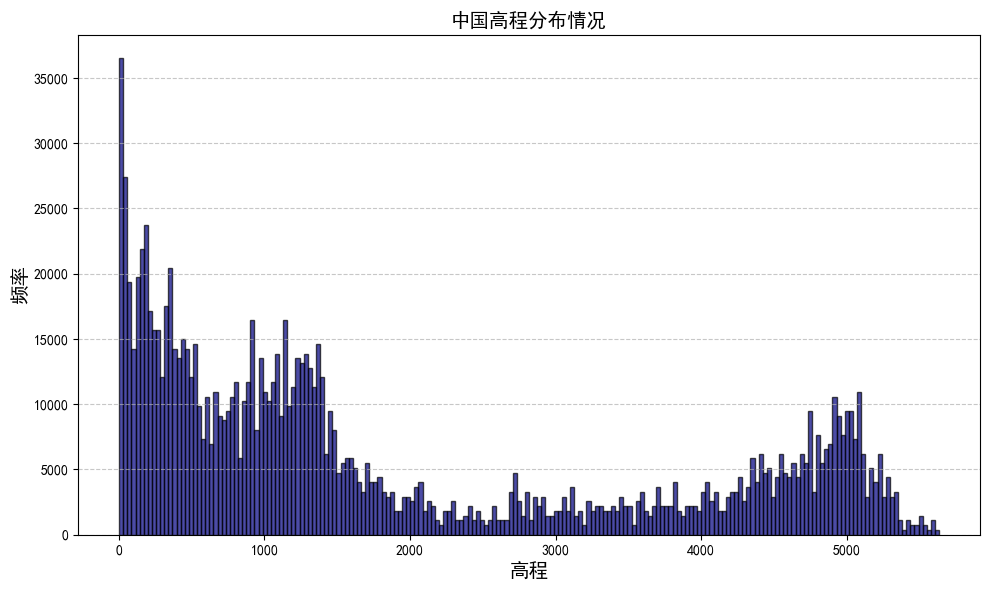

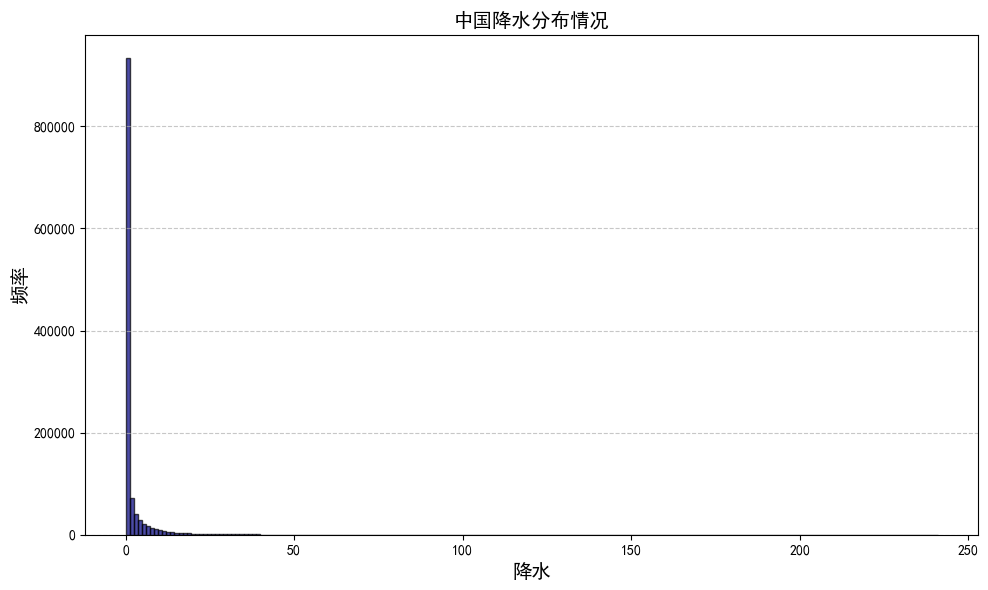

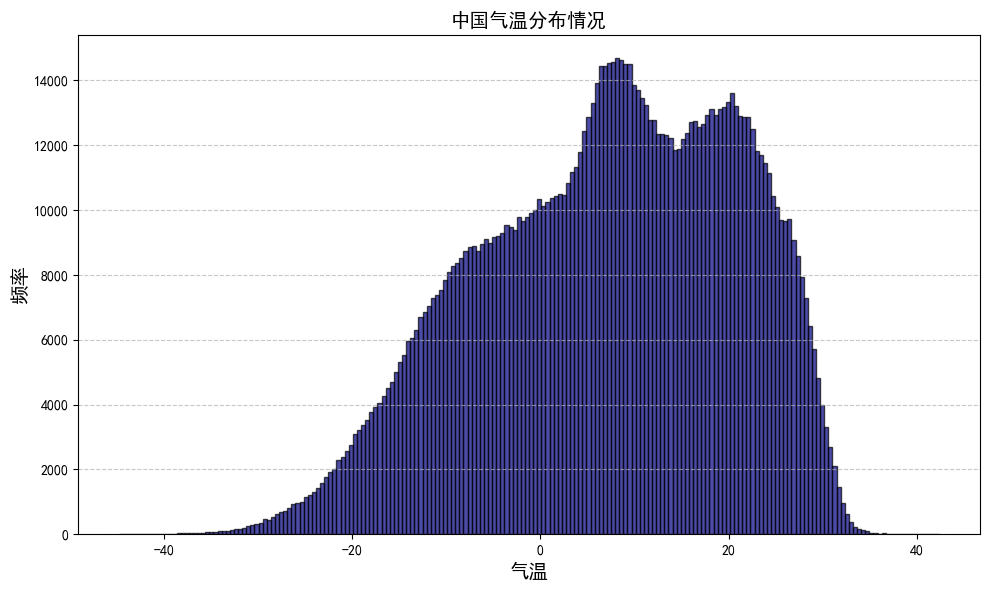

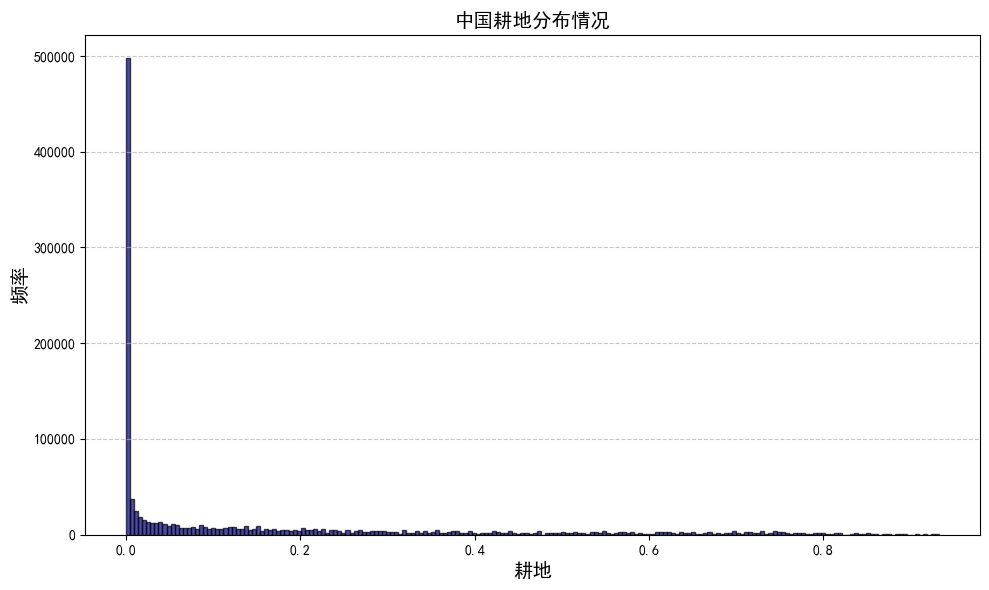

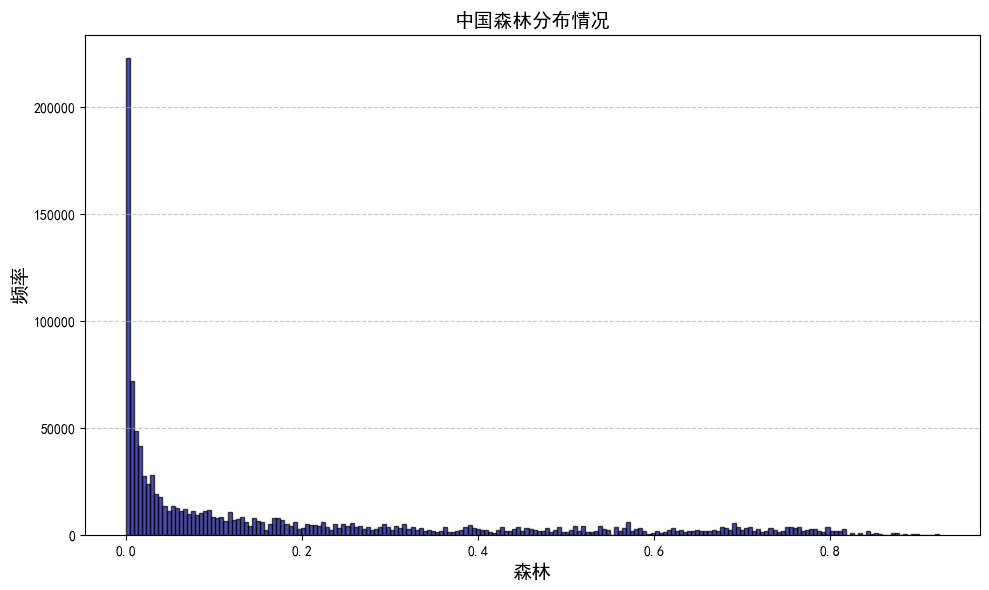

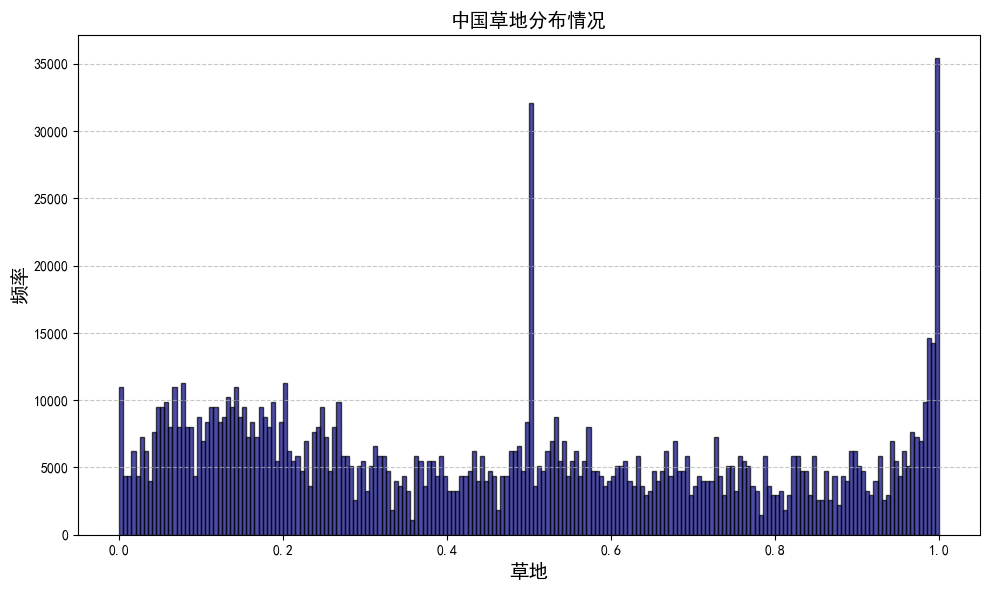

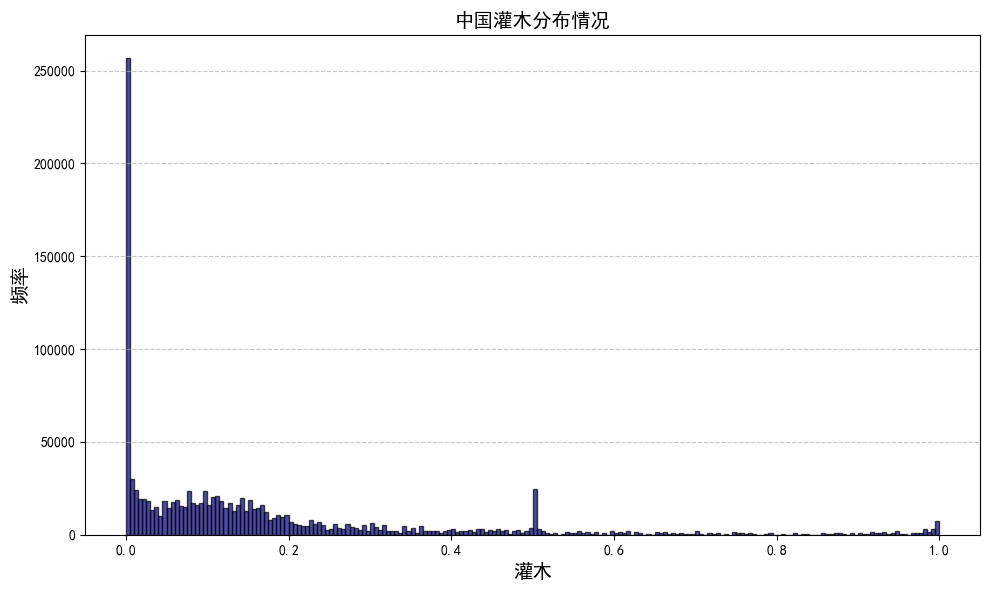

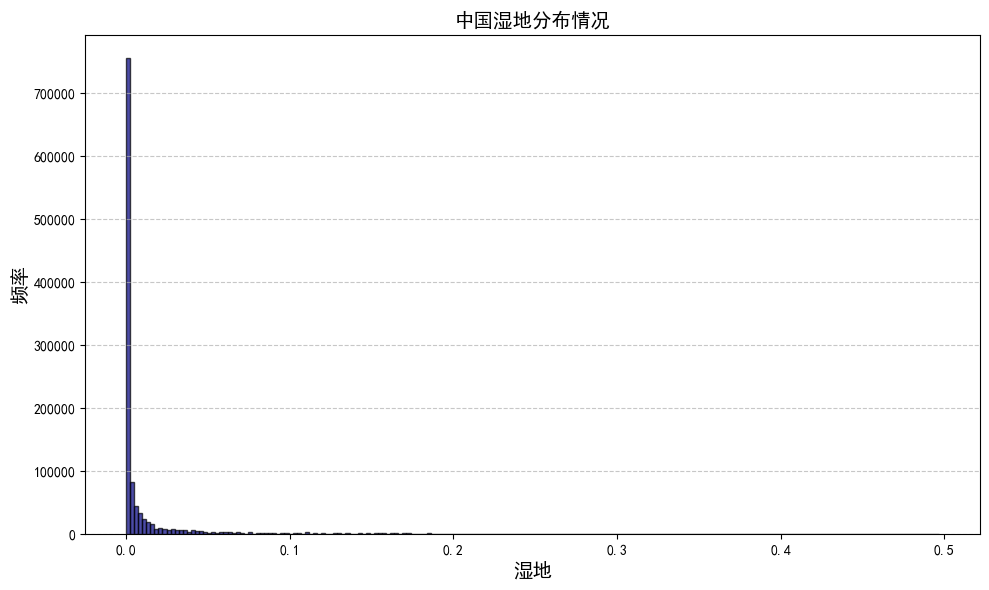

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 示例数据 - 生成一个随机的Series
for col in ['高程', '降水', '气温', '耕地', '森林', '草地', '灌木', '湿地']:
    data = pd.Series(result[col].values)  # 正态分布的随机数据

    # 创建直方图
    plt.figure(figsize=(10, 6))
    
    plt.hist(data, bins=200, color='navy', edgecolor='black', alpha=0.7)

    # 添加标题和标签
    plt.title(f'中国{col}分布情况', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('频率', fontsize=14)

    # 美化图表
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'F:\研究生学习\华为杯\第二问图片\\中国{col}分布情况.png', bbox_inches='tight')

    # 显示图表
    plt.tight_layout()
    plt.show()


#### 为了验证不同的地理因素对灾害的影响，我们使用统计逻辑回归来检验

In [13]:
import pandas as pd
import statsmodels.api as sm

col = ['高程', '降水', '气温', '耕地', '森林', '草地', '灌木', '湿地', '经度', '纬度']
# 添加常数项（截距）
X = sm.add_constant(result[col])  # 自变量
y = result['极端天气']  # 因变量

# 进行逻辑回归
model = sm.Logit(y, X)
state = model.fit()

# 输出模型结果
print(state.summary())

coef_df = pd.DataFrame(state.summary().tables[0])
pvalues_df = pd.DataFrame(state.summary().tables[1])

# 将三个表保存到不同的 Excel sheet 中
with pd.ExcelWriter(f'F:\研究生学习\华为杯\第二问图片\\各地理因素对灾害的影响作用.xlsx') as writer:
    coef_df.to_excel(writer, sheet_name='结果1')
    pvalues_df.to_excel(writer, sheet_name='结果2')


         Current function value: 0.056882
         Iterations: 35


D:\Anaconda3\envs\Py38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                   极端天气   No. Observations:              1189535
Model:                          Logit   Df Residuals:                  1189524
Method:                           MLE   Df Model:                           10
Date:                Sun, 22 Sep 2024   Pseudo R-squ.:                  0.1701
Time:                        19:33:48   Log-Likelihood:                -67663.
converged:                      False   LL-Null:                       -81536.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8034   1.85e+05  -2.59e-05      1.000   -3.64e+05    3.64e+05
高程            -0.0004   1.04e-05    -41.657      0.000      -0.000      -0.000
降水             0.0766      0.001    104.197      0.0

#### 可以明显的看到，高程、降水、气温、经纬度对自然灾害定义影响都是非常明显的，其中，高程对灾害有一些负向影响，如果高程越高，则灾害可能性越小，降水对自然灾害有一定的调节作用，虽然过多的降水会造成暴雨自然灾害，但实际对总的包括热浪、寒潮等灾害，起到的作用也是正向的。

#### 但是，统计逻辑回归的拟合效果太差，我们使用更高阶的随机森林

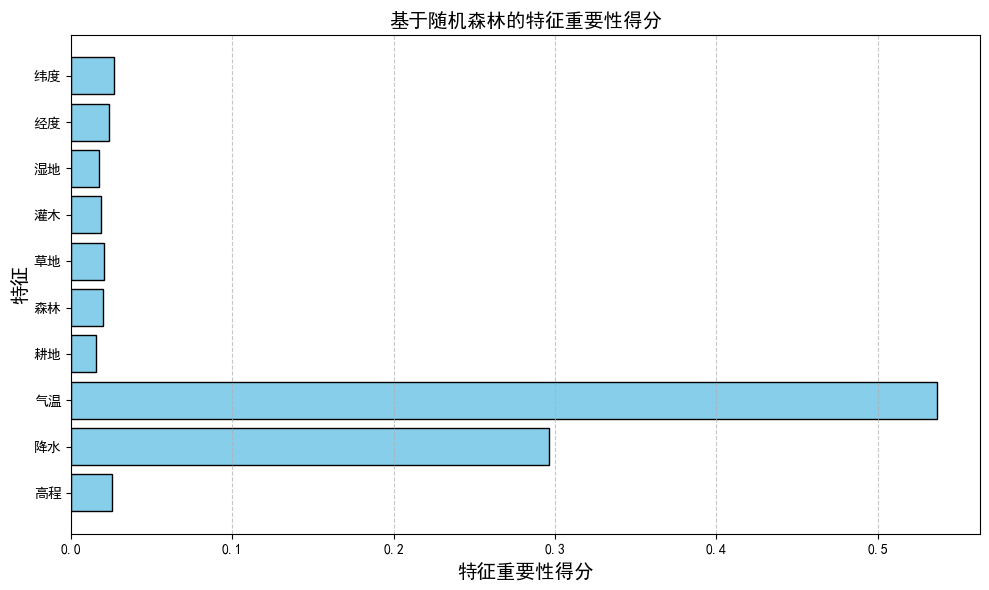

In [20]:

col = ['高程', '降水', '气温', '耕地', '森林', '草地', '灌木', '湿地', '经度', '纬度']


# 分离特征和目标变量
X = result[col].values # 特征变量
y = result['极端天气'].values  # 目标变量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 创建随机森林分类器
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 获取特征重要性得分
feature_importances = model.feature_importances_


# 创建条形图
plt.figure(figsize=(10, 6))
plt.barh(col, feature_importances, color='royalblue', edgecolor='black')
plt.xlabel('特征重要性得分',fontsize = 14)
plt.ylabel('特征',fontsize = 14)
plt.title('基于随机森林的特征重要性得分',fontsize = 14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'F:\研究生学习\华为杯\第二问图片\\基于随机森林的特征重要性得分.png', bbox_inches='tight')

# 显示图表
plt.show()

In [15]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出评价指标
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.99
Precision: 0.32
Recall: 0.13
F1-Score: 0.19


#### 本质上，这种低准确率的表现是因为数据过于不平衡，即自然灾害占极少样本的总量，所以模型倾向于将自然灾害的样本判别成无灾害情况，而不平衡学习并不在讨论范围内。但是，我们仍然可以用两个模型的共性来总结不同地理特征对自然灾害的影响。